In [1]:
library(data.table)
library(h2o)
library(e1071)

Warning message:
"package 'data.table' was built under R version 3.3.2"Warning message:
"package 'h2o' was built under R version 3.3.3"
Warning message:
"package 'e1071' was built under R version 3.3.2"

In [2]:
train = fread("train.csv",na.strings = c(""," ",NA))
test = fread("test.csv",na.strings = c(""," ",NA))

Read 0.0% of 532428 rows

Read 532428 rows and 45 (of 45) columns from 0.134 GB file in 00:00:09
Read 354951 rows and 44 (of 44) columns from 0.089 GB file in 00:00:04


In [3]:
str(train)

Classes 'data.table' and 'data.frame':	532428 obs. of  45 variables:
 $ member_id                  : int  58189336 70011223 70255675 1893936 7652106 10247268 8089625 23043116 45900933 41272507 ...
 $ loan_amnt                  : int  14350 4800 10000 15000 16000 15000 5000 6000 6000 34550 ...
 $ funded_amnt                : int  14350 4800 10000 15000 16000 15000 5000 6000 6000 34550 ...
 $ funded_amnt_inv            : num  14350 4800 10000 15000 16000 ...
 $ term                       : chr  "36 months" "36 months" "36 months" "36 months" ...
 $ batch_enrolled             : chr  NA "BAT1586599" "BAT1586599" "BAT4808022" ...
 $ int_rate                   : num  19.19 10.99 7.26 19.72 10.64 ...
 $ grade                      : chr  "E" "B" "A" "D" ...
 $ sub_grade                  : chr  "E3" "B4" "A4" "D5" ...
 $ emp_title                  : chr  "clerk" "Human Resources Specialist" "Driver" "Us office of Personnel Management" ...
 $ emp_length                 : chr  "9 years" "< 1 year

In [4]:
## Combine the training and testing dataset
total = rbindlist(list(train,test),fill = T)

In [5]:
summary(total)

   member_id          loan_amnt      funded_amnt    funded_amnt_inv
 Min.   :   70473   Min.   :  500   Min.   :  500   Min.   :    0  
 1st Qu.:10877134   1st Qu.: 8000   1st Qu.: 8000   1st Qu.: 8000  
 Median :37095283   Median :13000   Median :13000   Median :13000  
 Mean   :35001825   Mean   :14755   Mean   :14742   Mean   :14702  
 3rd Qu.:58471347   3rd Qu.:20000   3rd Qu.:20000   3rd Qu.:20000  
 Max.   :73544841   Max.   :35000   Max.   :35000   Max.   :35000  
                                                                   
     term           batch_enrolled        int_rate        grade          
 Length:887379      Length:887379      Min.   : 5.32   Length:887379     
 Class :character   Class :character   1st Qu.: 9.99   Class :character  
 Mode  :character   Mode  :character   Median :12.99   Mode  :character  
                                       Mean   :13.25                     
                                       3rd Qu.:16.20                     
            

In [6]:
## Check if ant variables are correlated to each other
num_col = colnames(total)[sapply(total, is.numeric)]
num_col = num_col[!(num_col %in% c("member_id","loan_status"))]

In [7]:
cor(train[,num_col,with=F])

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
loan_amnt,1.00000000,0.99927623,0.99712350,0.14503673,NA,0.041866185,NA,NA,NA,NA,...,0.53257978,0.03137357,0.073326472,0.052995305,NA,NA,NA,NA,NA,NA
funded_amnt,0.99927623,1.00000000,0.99804075,0.14522240,NA,0.042698516,NA,NA,NA,NA,...,0.53161606,0.03102161,0.072894772,0.052796600,NA,NA,NA,NA,NA,NA
funded_amnt_inv,0.99712350,0.99804075,1.00000000,0.14525122,NA,0.044951785,NA,NA,NA,NA,...,0.52911618,0.02777038,0.071242437,0.050261255,NA,NA,NA,NA,NA,NA
int_rate,0.14503673,0.14522240,0.14525122,1.00000000,NA,0.163205612,NA,NA,NA,NA,...,0.44563431,0.05614080,0.107291547,0.071187324,NA,NA,NA,NA,NA,NA
annual_inc,NA,NA,NA,NA,1,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
dti,0.04186619,0.04269852,0.04495178,0.16320561,NA,1.000000000,NA,NA,NA,NA,...,0.01847520,-0.01133623,0.002543509,0.003708169,NA,NA,NA,NA,NA,NA
delinq_2yrs,NA,NA,NA,NA,NA,NA,1,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
inq_last_6mths,NA,NA,NA,NA,NA,NA,NA,1,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
mths_since_last_delinq,NA,NA,NA,NA,NA,NA,NA,NA,1,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
mths_since_last_record,NA,NA,NA,NA,NA,NA,NA,NA,NA,1,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [8]:
## 'funded_amnt', 'funded_amnt_inv' and 'collection_recovery_fee' are highly correlated. Let's remove them
total$funded_amnt = NULL
total$funded_amnt_inv = NULL
total$collection_recovery_fee = NULL

In [9]:
## Remove the columns with very high missing values also
total$mths_since_last_delinq = NULL
total$mths_since_last_record = NULL
total$mths_since_last_major_derog = NULL

In [10]:
## Analyse the 'verification_status_joint','application_type' and 'pymnt_plan' variable

In [11]:
table(as.factor(total$verification_status_joint))


   Not Verified Source Verified        Verified 
            283              61             167 

In [12]:
table(as.factor(total$application_type))


INDIVIDUAL      JOINT 
    886868        511 

In [13]:
table(as.factor(total$pymnt_plan))


     n      y 
887369     10 

In [14]:
## In above all three variables, a large number of observations are either missing or are of same type. So there is no point
## in involving them
total$verification_status_joint = NULL
total$application_type = NULL
total$pymnt_plan = NULL

In [15]:
summary(as.factor(total$desc))

> Debt consolidation<br> 
                                                   958 
                              > Debt Consolidation<br> 
                                                   624 
                              > debt consolidation<br> 
                                                   570 
                             > Debt consolidation.<br> 
                                                   210 
                            > Pay off credit cards<br> 
                                                   205 
                       > Credit card consolidation<br> 
                                                   181 
                            > pay off credit cards<br> 
                                                   172 
                       > credit card consolidation<br> 
                                                   110 
                                   > Consolidation<br> 
                                                    97 
                       > Credit Card Consolidation<br> 
                                                    95 
                         > To pay off credit cards<br> 
                                                    86 
                              > DEBT CONSOLIDATION<br> 
                                                    74 
                         > Credit card refinancing<br> 
                                                    73 
                             > Debt Consolidation.<br> 
                                                    62 
              > Pay off high interest credit cards<br> 
                                                    58 
                        > Consolidate credit cards<br> 
                                                    57 
                                > Consolidate debt<br> 
                                                    57 
                         > to pay off credit cards<br> 
                                                    55 
                        > consolidate credit cards<br> 
                                                    54 
                         > credit card refinancing<br> 
                                                    49 
                                > home improvement<br> 
                                                    49 
                                > Home Improvement<br> 
                                                    49 
                           > Pay off credit cards.<br> 
                                                    49 
                                   > consolidation<br> 
                                                    47 
                      > Credit card consolidation.<br> 
                                                    46 
                  > Credit card debt consolidation<br> 
                                                    45 
                        > Pay off credit card debt<br> 
                                                    45 
                         > Credit Card Refinancing<br> 
                                                    44 
                    > Consolidate credit card debt<br> 
                                                    41 
                              > credit card payoff<br> 
                                                    38 
                                > Home improvement<br> 
                                                    38 
                        > To pay off credit cards.<br> 
                                                    36 
           > To pay off high interest credit cards<br> 
                                                    36 
                  > Credit Card Debt Consolidation<br> 
                                                    34 
                               > Consolidate bills<br> 
                                                    33 
                   > Consolidate credit card debt.<br> 
                                                    33

In [16]:
## Words like 'Debt consolidation','credit consolidation', etc can be extracted from it and group them. It also has very large
## number of missing values. So I'm dropping it
total$desc = NULL

In [17]:
summary(as.factor(total$batch_enrolled))

BAT2252229 BAT3873588 BAT2803411 BAT2078974 BAT1586599 BAT1780517 BAT1104812 
     18791      17839      17111      14859      14463      13918      13505 
BAT4694572 BAT1184694 BAT3193689 BAT4271519 BAT3726927 BAT5260863 BAT4136152 
     13504      12251      11189      10994      10977       9972       9667 
BAT2558388 BAT5662637 BAT5924421 BAT6004464 BAT6248271 BAT4106493 BAT2136391 
      9601       9379       9071       9000       7957       7694       7422 
BAT4664105 BAT6612051 BAT5489674 BAT2333412 BAT5060554 BAT3461431 BAT3840785 
      7321       7306       7291       7192       7139       6583       6514 
BAT2522922 BAT5319342 BAT1766061  BAT224923 BAT5241177 BAT5629144  BAT422167 
      6250       6062       5997       5858       5855       5731       5679 
BAT2575549 BAT1930365 BAT4268557 BAT4127326 BAT4351734 BAT5525466 BAT4729018 
      5638       5378       5248       5107       4971       4926       4905 
BAT2833642 BAT4808022 BAT2003848 BAT4722912 BAT2428731 BAT3274746  BAT446479 
      4595       4181       4129       4043       4004       3990       3847 
BAT4217242 BAT5341619 BAT4818662 BAT3016651 BAT5714674 BAT5349407 BAT4711174 
      3840       3598       3498       3343       3231       3131       3129 
BAT5019662 BAT3563724 BAT3938478 BAT3865626 BAT1467036 BAT4031849 BAT3780546 
      3116       3030       2900       2847       2705       2652       2566 
BAT5547201 BAT3041298 BAT5811547 BAT1761981 BAT5849876 BAT3404765  BAT338166 
      2459       2428       2412       2400       2357       2256       2153 
BAT1135695 BAT3369838 BAT4318899 BAT3141736 BAT3943761 BAT5046402  BAT528686 
      2041       2018       2013       1946       1814       1718       1544 
BAT3292317 BAT4138794 BAT2677031 BAT5907542 BAT3554832 BAT3372536 BAT4408664 
      1449       1375       1337       1329       1278       1247       1180 
BAT6352293 BAT3058155 BAT1327206   BAT47674 BAT5046385 BAT5737941 BAT1942645 
      1179       1103       1102        976        961        928        890 
BAT2015867 BAT2881062 BAT1914408 BAT5903747 BAT4780022 BAT5877328 BAT5181914 
       849        846        826        815        745        701        674 
   (Other)       NA's 
     22705     364835

In [18]:
## It can be dropped due to large number of missing values. But I want to utilise it. Let's convert it into integer
total$batch_enrolled = as.factor(total$batch_enrolled)
total$batch_enrolled = as.integer(total$batch_enrolled) - 1

In [19]:
## Now make another column having value 1 if NA and 0 otherwise. Also fill the missing values with some dummy value
total$batch_enrolled_NA = ifelse(is.na(total$batch_enrolled),1,0)
total$batch_enrolled[is.na(total$batch_enrolled)] = -1

In [20]:
summary(total$batch_enrolled)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -1.00   -1.00   18.00   48.99   93.00  205.00 

In [21]:
## Same as above, it can also be done in 'tot_coll_amt','tot_cur_bal' and 'total_rev_hi_lim' as they all have high missing values
total$tot_coll_amt_NA = ifelse(is.na(total$tot_coll_amt),1,0)
total$tot_cur_bal_NA = ifelse(is.na(total$tot_cur_bal),1,0)
total$total_rev_hi_lim_NA = ifelse(is.na(total$total_rev_hi_lim),1,0)

In [22]:
total$tot_coll_amt[is.na(total$tot_coll_amt)] = -1
total$tot_cur_bal[is.na(total$tot_cur_bal)] = -1
total$total_rev_hi_lim[is.na(total$total_rev_hi_lim)] = -1

In [23]:
table(total$tot_coll_amt_NA[1:nrow(train)], train$loan_status)

   
         0      1
  0 397921  92503
  1   8680  33324

In [24]:
## One-Hot_Encoding can be done on few of the columns. Let's do it

In [25]:
## Extract the 'term','grade' and 'verification_status' columns for OHE
total_mod = total[,.(term,grade,verification_status)]

In [26]:
total_ex = model.matrix(~.+0, data = total_mod)
total_ex = as.data.table(total_ex)

In [27]:
new_total = cbind(total,total_ex)
new_total[,c("term","grade","verification_status")] = NULL

In [28]:
total = new_total

In [29]:
## Remove the used objects to free up memory
rm(new_total,total_mod,total_ex)

In [30]:
## Rest of the character variables can be converted to integer. Let's write a function for it

for(i in colnames(total)[sapply(total, is.character)])
  set(x = total, j = i, value = as.integer(as.factor(total[[i]]))-1)

In [31]:
summary(total)

   member_id          loan_amnt     batch_enrolled      int_rate    
 Min.   :   70473   Min.   :  500   Min.   : -1.00   Min.   : 5.32  
 1st Qu.:10877134   1st Qu.: 8000   1st Qu.: -1.00   1st Qu.: 9.99  
 Median :37095283   Median :13000   Median : 18.00   Median :12.99  
 Mean   :35001825   Mean   :14755   Mean   : 48.99   Mean   :13.25  
 3rd Qu.:58471347   3rd Qu.:20000   3rd Qu.: 93.00   3rd Qu.:16.20  
 Max.   :73544841   Max.   :35000   Max.   :205.00   Max.   :28.99  
                                                                    
   sub_grade       emp_title        emp_length     home_ownership 
 Min.   : 0.00   Min.   :     0   Min.   : 0.000   Min.   :0.000  
 1st Qu.: 6.00   1st Qu.: 76186   1st Qu.: 2.000   1st Qu.:1.000  
 Median :10.00   Median :154127   Median : 3.000   Median :3.000  
 Mean   :10.96   Mean   :148902   Mean   : 4.109   Mean   :2.901  
 3rd Qu.:15.00   3rd Qu.:218313   3rd Qu.: 6.000   3rd Qu.:5.000  
 Max.   :34.00   Max.   :289206   Max.   :11.0

In [32]:
## Remaining columns have now very few missing values. Let's replace them with their medians
total[] = lapply(total, function(x) ifelse(is.na(x), median(x, na.rm = TRUE), x))

In [33]:
summary(total)

   member_id          loan_amnt     batch_enrolled      int_rate    
 Min.   :   70473   Min.   :  500   Min.   : -1.00   Min.   : 5.32  
 1st Qu.:10877134   1st Qu.: 8000   1st Qu.: -1.00   1st Qu.: 9.99  
 Median :37095283   Median :13000   Median : 18.00   Median :12.99  
 Mean   :35001825   Mean   :14755   Mean   : 48.99   Mean   :13.25  
 3rd Qu.:58471347   3rd Qu.:20000   3rd Qu.: 93.00   3rd Qu.:16.20  
 Max.   :73544841   Max.   :35000   Max.   :205.00   Max.   :28.99  
   sub_grade       emp_title        emp_length     home_ownership 
 Min.   : 0.00   Min.   :     0   Min.   : 0.000   Min.   :0.000  
 1st Qu.: 6.00   1st Qu.: 81362   1st Qu.: 2.000   1st Qu.:1.000  
 Median :10.00   Median :154127   Median : 3.000   Median :3.000  
 Mean   :10.96   Mean   :149205   Mean   : 4.109   Mean   :2.901  
 3rd Qu.:15.00   3rd Qu.:214764   3rd Qu.: 6.000   3rd Qu.:5.000  
 Max.   :34.00   Max.   :289206   Max.   :11.000   Max.   :5.000  
   annual_inc         purpose           title   

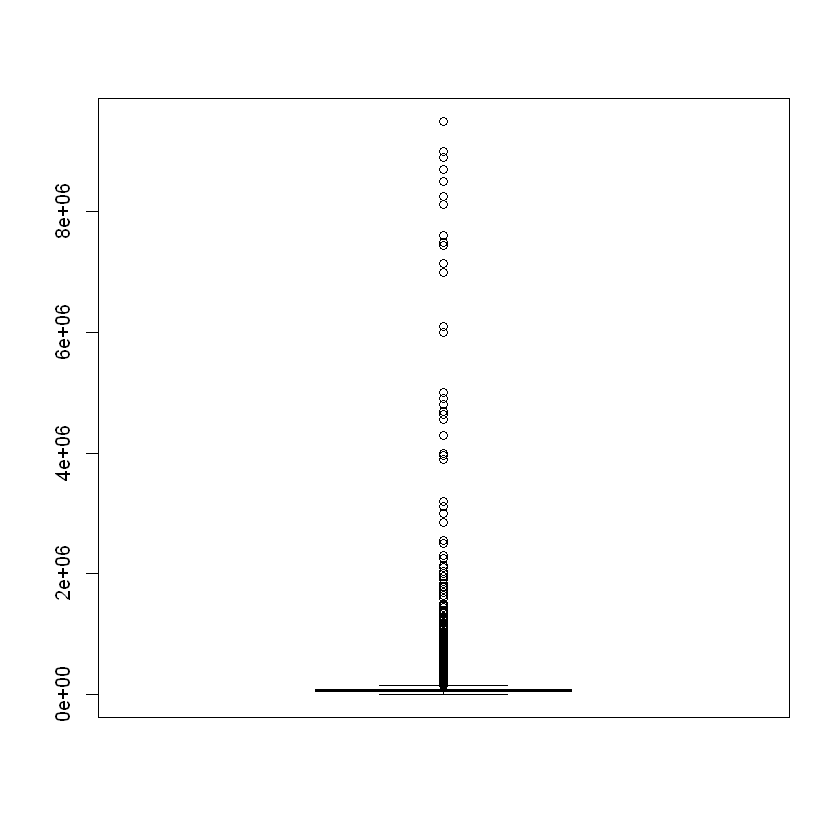

In [34]:
## Many of the columns have outliers
boxplot(total$annual_inc)

In [35]:
## Take log of the column to reduce the variability
total$annual_inc = log10(total$annual_inc + 10)

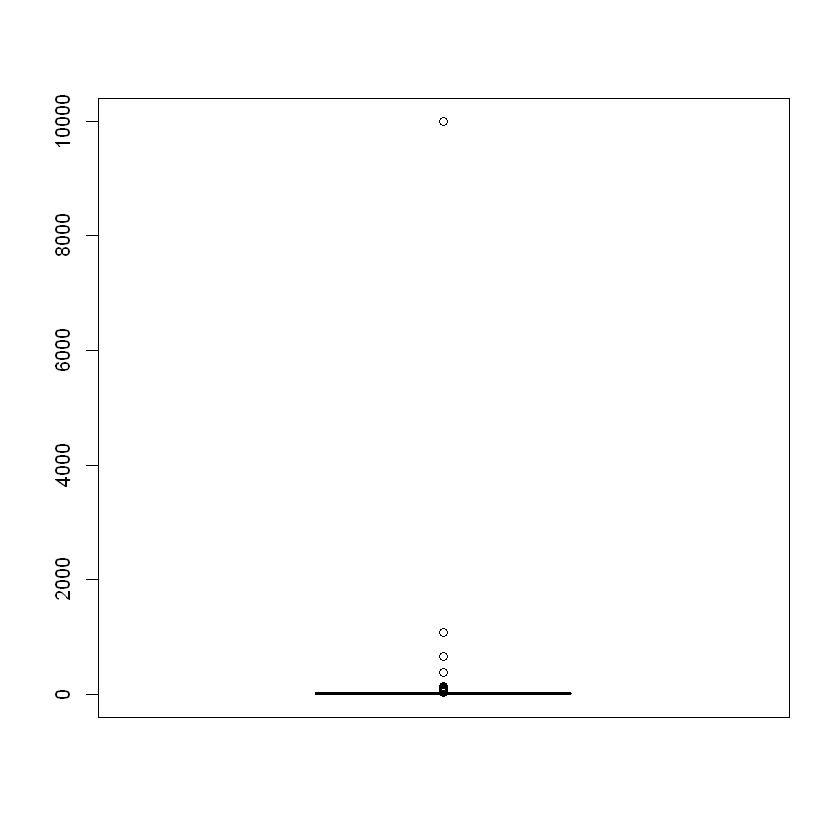

In [36]:
boxplot(total$dti)

In [37]:
total$dti = log10(total$dti+10)

In [38]:
## Similarly we can do this for other columns as well. Let's check skewness for all the columns

In [39]:
colNames = colnames(total)
colNames = colNames[!(colNames %in% "loan_status")]

In [40]:
skew = sapply(total[,colNames,with=F], function(x) skewness(x,na.rm = T))
skew

member_id                          loan_amnt 
                        0.01741206                         0.68168084 
                    batch_enrolled                           int_rate 
                        1.00228515                         0.42947918 
                         sub_grade                          emp_title 
                        0.57094277                        -0.15800760 
                        emp_length                     home_ownership 
                        0.77671245                         0.05681606 
                        annual_inc                            purpose 
                        0.20148792                         2.46474532 
                             title                           zip_code 
                        1.72256432                         0.02366285 
                        addr_state                                dti 
                        0.05924773                        -0.43099515 
                       delinq_2yrs                     inq_last_6mths 
                        5.47386536                         2.10844550 
                          open_acc                            pub_rec 
                        1.24940588                        13.26207152 
                         revol_bal                         revol_util 
                       15.94924769                        -0.12396980 
                         total_acc                initial_list_status 
                        0.89256056                         0.05934000 
                     total_rec_int                 total_rec_late_fee 
                        2.82609023                        17.40402656 
                        recoveries         collections_12_mths_ex_med 
                       18.06177786                        17.41176729 
                     last_week_pay                     acc_now_delinq 
                       -0.71450229                        24.06667013 
                      tot_coll_amt                        tot_cur_bal 
                      892.19072901                         2.92347589 
                  total_rev_hi_lim                  batch_enrolled_NA 
                       70.11084249                         0.36119860 
                   tot_coll_amt_NA                     tot_cur_bal_NA 
                        3.11657338                         3.11657338 
               total_rev_hi_lim_NA                      term36 months 
                        3.11657338                        -0.87263414 
                     term60 months                             gradeB 
                        0.87263414                         0.94259222 
                            gradeC                             gradeD 
                        0.99625752                         1.88303142 
                            gradeE                             gradeF 
                        3.10434956                         5.96080779 
                            gradeG verification_statusSource Verified 
                       12.59645402                         0.53237963 
       verification_statusVerified 
                        0.73265861

In [41]:
## Extract the columns with skewness > 6
skew = skew[skew > 6]
total[,(names(skew)) := lapply(.SD, function(x) log(x + 10)), .SDcols = names(skew)]

member_id,loan_amnt,batch_enrolled,int_rate,sub_grade,emp_title,emp_length,home_ownership,annual_inc,purpose,...,term36 months,term60 months,gradeB,gradeC,gradeD,gradeE,gradeF,gradeG,verification_statusSource Verified,verification_statusVerified
58189336,14350,-1,19.19,22,49398.0,10,4,4.458033,2,...,1,0,0,0,0,1,0,2.302585,1,0
70011223,4800,8,10.99,8,121407.0,0,1,4.812980,4,...,1,0,1,0,0,0,0,2.302585,1,0
70255675,10000,8,7.26,3,82279.0,3,4,4.653309,2,...,1,0,0,0,0,0,0,2.302585,0,0
1893936,15000,129,19.72,19,273869.0,2,5,5.021231,2,...,1,0,0,0,1,0,0,2.302585,0,0
7652106,16000,34,10.64,6,139281.0,2,5,4.716087,1,...,1,0,1,0,0,0,0,2.302585,0,1
10247268,15000,31,8.90,4,71578.0,3,1,5.079217,2,...,1,0,0,0,0,0,0,2.302585,0,0
8089625,5000,-1,7.90,3,266075.0,6,5,4.875119,2,...,1,0,0,0,0,0,0,2.302585,1,0
23043116,6000,-1,9.17,5,24972.0,9,1,4.732474,1,...,1,0,1,0,0,0,0,2.302585,0,0
45900933,6000,93,13.99,13,148647.0,8,1,4.963835,4,...,1,0,0,1,0,0,0,2.302585,0,0
41272507,34550,119,17.14,18,209156.0,3,1,4.857393,2,...,0,1,0,0,1,0,0,2.302585,0,1


In [42]:
## Check the memory usage and free up memory
sort(sapply(ls(),function(x){object.size(get(x))}))

i      skew   num_col  colNames      test     train     total 
      104       984      1736      2984 127747800 194800408 319465584

In [43]:
train_n = head(total,nrow(train))
test_n = tail(total,nrow(test))

In [44]:
rm(i,skew,colNames,test,train,total)

In [45]:
## Initialise the h2o package
h2o.init(nthreads = -1,max_mem_size = "10G")


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\MANISH~1\AppData\Local\Temp\RtmpUPSUzl/h2o_Manish_K_Sihag_started_from_r.out
    C:\Users\MANISH~1\AppData\Local\Temp\RtmpUPSUzl/h2o_Manish_K_Sihag_started_from_r.err


Starting H2O JVM and connecting: ....... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         19 seconds 893 milliseconds 
    H2O cluster version:        3.10.3.6 
    H2O cluster version age:    1 month and 8 days  
    H2O cluster name:           H2O_started_from_R_Manish_K_Sihag_gko108 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   8.89 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.1 (2016-06-21) 



In [46]:
h2o_train = as.h2o(train_n)
h2o_test = as.h2o(test_n)

  |======================================================================| 100%
  |======================================================================| 100%


In [47]:
h2o_train$loan_status = h2o.asfactor(h2o_train$loan_status)

In [57]:
## Make a validation frame
xd = h2o.splitFrame(h2o_train,ratios = 0.6)
split_val = xd[[2]]
y = "loan_status"
x = setdiff(colnames(train_n), c("loan_status","member_id"))

In [58]:
## Build a logistic regression model
glm.model = h2o.glm(y = y,
                    x = x,
                    training_frame = h2o_train,
                    validation_frame = split_val,
                    family = "binomial")

  |======================================================================| 100%


In [59]:
## Check its performance
summary(glm.model)

Model Details:

H2OBinomialModel: glm
Model Key:  GLM_model_R_1490821852467_138 
GLM Model: summary
    family  link                               regularization
1 binomial logit Elastic Net (alpha = 0.5, lambda = 3.26E-4 )
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                         44                          44                    9
   training_frame
1 RTMP_sid_b7d1_3

H2OBinomialMetrics: glm
** Reported on training data. **

MSE:  0.118193
RMSE:  0.3437921
LogLoss:  0.3838624
Mean Per-Class Error:  0.2353681
AUC:  0.8463899
Gini:  0.6927799
R^2:  0.3451056
Null Deviance:  582272.6
Residual Deviance:  408758.2
AIC:  408848.2

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
            0      1    Error           Rate
0      355343  51258 0.126065  =51258/406601
1       43369  82458 0.344672  =43369/125827
Totals 398712 133716 0.177727  =94627/532428

Maximum Metrics: Maximum metrics at their respective thresh

In [60]:
## AUC value is 0.84 Let's see how dlearning performs

In [61]:
## Build the model
dlearning.model = h2o.deeplearning(y = y,
             x = x,
             training_frame = h2o_train,
             validation_frame = split_val,
             epoch = 60,
             hidden = c(100,100),
             activation = "Rectifier",
             seed = 1122
             )

  |======================================================================| 100%


In [62]:
summary(dlearning.model)

Model Details:

H2OBinomialModel: deeplearning
Model Key:  DeepLearning_model_R_1490821852467_141 
Status of Neuron Layers: predicting loan_status, 2-class classification, bernoulli distribution, CrossEntropy loss, 14,802 weights/biases, 187.7 KB, 19,700,504 training samples, mini-batch size 1
  layer units      type dropout       l1       l2 mean_rate rate_rms momentum
1     1    44     Input  0.00 %                                              
2     2   100 Rectifier  0.00 % 0.000000 0.000000  0.006251 0.009614 0.000000
3     3   100 Rectifier  0.00 % 0.000000 0.000000  0.020351 0.101133 0.000000
4     4     2   Softmax         0.000000 0.000000  0.006050 0.069520 0.000000
  mean_weight weight_rms mean_bias bias_rms
1                                          
2    0.025836   1.414043 -0.459904 1.021664
3   -0.090855   0.355193  0.566960 0.965845
4   -0.012985   0.513743 -0.066271 0.934223

H2OBinomialMetrics: deeplearning
** Reported on training data. **
** Metrics reported on tempo

In [63]:
## AUC value is approx 0.92. This is certainly an improvement

In [64]:
## Let's make predictions on test set and write the submission file

In [65]:
dlearning_pred = as.data.table(h2o.predict(dlearning.model,h2o_test))

  |======================================================================| 100%


In [66]:
summary(dlearning_pred)

 predict          p0               p1         
 0:240249   Min.   :0.0000   Min.   :0.00000  
 1:114702   1st Qu.:0.4356   1st Qu.:0.03361  
            Median :0.8691   Median :0.13086  
            Mean   :0.6895   Mean   :0.31053  
            3rd Qu.:0.9664   3rd Qu.:0.56444  
            Max.   :1.0000   Max.   :1.00000  

In [76]:
submission = data.table(member_id = test_n$member_id, loan_status = dlearning_pred$p1)

In [78]:
fwrite(submission,"final_submission.csv", row.names = F)